In [1]:
import os
import glob

cars_paths = []
no_cars_paths = []

cars_paths.extend(glob.glob('vehicles/*/*.png'))
no_cars_paths.extend(glob.glob('non-vehicles/*/*.png'))

In [2]:
print ('Number of non-cars: ', len(no_cars_paths))

Number of non-cars:  8968


In [3]:
print ('Number of cars: ', len(cars_paths))

Number of cars:  8792


In [4]:
import matplotlib.image as mpimg
import matplotlib.pyplot as plt
import numpy as np
import pickle
import cv2
import time
from sklearn.svm import LinearSVC
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from skimage.feature import hog


# Define the feature extractor

In [99]:
# Define a function to return HOG features and visualization
def get_hog_features(img, orient, pix_per_cell, cell_per_block, 
                        vis=False, feature_vec=True):
    # Call with two outputs if vis==True
    if vis == True:
        features, hog_image = hog(img, orientations=orient, 
                                  pixels_per_cell=(pix_per_cell, pix_per_cell),
                                  cells_per_block=(cell_per_block, cell_per_block), 
                                  transform_sqrt=True, 
                                  visualise=vis, feature_vector=feature_vec)
        return features, hog_image
    # Otherwise call with one output
    else:      
        features = hog(img, orientations=orient, 
                       pixels_per_cell=(pix_per_cell, pix_per_cell),
                       cells_per_block=(cell_per_block, cell_per_block), 
                       transform_sqrt=True, 
                       visualise=vis, feature_vector=feature_vec)
        return features

# Define a function to compute binned color features  
def bin_spatial(img, size=(32, 32)):
    # Use cv2.resize().ravel() to create the feature vector
    features = cv2.resize(img, size).ravel() 
    # Return the feature vector
    return features

# Define a function to compute color histogram features  
def color_hist(img, nbins=32, bins_range=(0, 256)):
    # Compute the histogram of the color channels separately
    channel1_hist = np.histogram(img[:,:,0], bins=nbins, range=bins_range)
    channel2_hist = np.histogram(img[:,:,1], bins=nbins, range=bins_range)
    channel3_hist = np.histogram(img[:,:,2], bins=nbins, range=bins_range)
    # Concatenate the histograms into a single feature vector
    hist_features = np.concatenate((channel1_hist[0], channel2_hist[0], channel3_hist[0]))
    # Return the individual histograms, bin_centers and feature vector
    return hist_features

def convert_color(img, color_space='HSV'):
    if color_space != 'RGB':
        return img
    color_conversion = {
       'HSV' : cv2.COLOR_RGB2HSV,
       'LUV' : cv2.COLOR_RGB2LUV,
       'HLS' : cv2.COLOR_RGB2HLS,
       'YUV' : cv2.COLOR_RGB2YUV,
       'YCrCb' : cv2.COLOR_RGB2YCrCb
       }
    return cv2.cvtColor(feature_image, color_conversion[color_space])
    

# Define a function to extract features from a list of images
# Have this function call bin_spatial() and color_hist()
def extract_features(imgs, color_space='HSV', spatial_size=(32, 32),
                        hist_bins=32, orient=9, 
                        pix_per_cell=8, cell_per_block=2, hog_channel=0,
                        spatial_feat=True, hist_feat=True, hog_feat=True):
    # Create a list to append feature vectors to
    features = []
    # Iterate through the list of images
    for file in imgs:
        file_features = []
        # Read in each one by one
        feature_image = mpimg.imread(file)
#        feature_image = img.astype(np.float32)/255

        # apply color conversion if other than 'RGB'
        feature_image = convert_color(feature_image, color_space)
        if spatial_feat == True:
            spatial_features = bin_spatial(feature_image, size=spatial_size)
            file_features.append(spatial_features)
        if hist_feat == True:
            # Apply color_hist()
            hist_features = color_hist(feature_image, nbins=hist_bins)
            file_features.append(hist_features)
        if hog_feat == True:
        # Call get_hog_features() with vis=False, feature_vec=True
            if hog_channel == 'ALL':
                hog_features = []
                for channel in range(feature_image.shape[2]):
                    hog_features.append(get_hog_features(feature_image[:,:,channel], 
                                        orient, pix_per_cell, cell_per_block, 
                                        vis=False, feature_vec=True))
                hog_features = np.ravel(hog_features)        
            else:
                hog_features = get_hog_features(feature_image[:,:,hog_channel], orient, 
                            pix_per_cell, cell_per_block, vis=False, feature_vec=True)
            # Append the new feature vector to the features list
            file_features.append(hog_features)
        features.append(np.concatenate(file_features))
    # Return list of feature vectors
    return features

# Train the classifier
I wanted to be conservative here and I started with just the S channel and 24 bin sizes.
But then I wanted to maximize the accuracy and got 0.989 at bin 32 all channels and 9 hog orientations.
Will scale down to get more performace if needed.

In [235]:
# TODO play with these values to see how your classifier
# performs under different binning scenarios
color_space = 'YCrCb' # Can be RGB, HSV, LUV, HLS, YUV, YCrCb
orient = 12  # HOG orientations
pix_per_cell = 8 # HOG pixels per cell
cell_per_block = 2 # HOG cells per block
hog_channel = "ALL" # Can be 0, 1, 2, or "ALL"
spatial_size = (18, 18) # Spatial binning dimensions
hist_bins = 52    # Number of histogram bins
spatial_feat = True # Spatial features on or off
hist_feat = True # Histogram features on or off
hog_feat = True # HOG features on or off

In [236]:
car_features = extract_features(cars_paths, color_space=color_space, 
                        spatial_size=spatial_size, hist_bins=hist_bins, 
                        orient=orient, pix_per_cell=pix_per_cell, 
                        cell_per_block=cell_per_block, 
                        hog_channel=hog_channel, spatial_feat=spatial_feat, 
                        hist_feat=hist_feat, hog_feat=hog_feat)
notcar_features = extract_features(no_cars_paths, color_space=color_space, 
                        spatial_size=spatial_size, hist_bins=hist_bins, 
                        orient=orient, pix_per_cell=pix_per_cell, 
                        cell_per_block=cell_per_block, 
                        hog_channel=hog_channel, spatial_feat=spatial_feat, 
                        hist_feat=hist_feat, hog_feat=hog_feat)

# Create an array stack of feature vectors
X = np.vstack((car_features, notcar_features)).astype(np.float64)                        
# Fit a per-column scaler
X_scaler = StandardScaler().fit(X)
# Apply the scaler to X
scaled_X = X_scaler.transform(X)

# Define the labels vector
y = np.hstack((np.ones(len(car_features)), np.zeros(len(notcar_features))))


# Split up data into randomized training and test sets
rand_state = np.random.randint(0, 100)
X_train, X_test, y_train, y_test = train_test_split(
    scaled_X, y, test_size=0.2, random_state=rand_state)

print('Using spatial binning of:',spatial_size,
    'and', hist_bins,'histogram bins')
print('Feature vector length:', len(X_train[0]))
# Use a linear SVC 
svc = LinearSVC()
# Check the training time for the SVC
t=time.time()
svc.fit(X_train, y_train)
t2 = time.time()
print(round(t2-t, 2), 'Seconds to train SVC...')
# Check the score of the SVC
print('Test Accuracy of SVC = ', round(svc.score(X_test, y_test), 4))
# Check the prediction time for a single sample
t=time.time()
n_predict = 10
print('My SVC predicts: ', svc.predict(X_test[0:n_predict]))
print('For these',n_predict, 'labels: ', y_test[0:n_predict])
t2 = time.time()
print(round(t2-t, 5), 'Seconds to predict', n_predict,'labels with SVC')

Using spatial binning of: (18, 18) and 52 histogram bins
Feature vector length: 8184
36.53 Seconds to train SVC...
Test Accuracy of SVC =  0.9755
My SVC predicts:  [ 1.  0.  1.  0.  1.  1.  0.  0.  1.  0.]
For these 10 labels:  [ 1.  0.  1.  1.  1.  1.  0.  0.  1.  0.]
0.01303 Seconds to predict 10 labels with SVC


# Define the function that processes frames

In [237]:
# Define a single function that can extract features using hog sub-sampling and make predictions
def find_bboxes(img, xstart, xstop, ystart, ystop, scale, svc, X_scaler, orient, pix_per_cell, cell_per_block, spatial_size, hist_bins, color_space=color_space):
    draw_img = np.copy(img)
    #img = img.astype(np.float32)/255
    #print(np.amax(img))
    
    img_tosearch = img[ystart:ystop,xstart:xstop,:]
    ctrans_tosearch = convert_color(img_tosearch, color_space)
    if scale != 1:
        imshape = ctrans_tosearch.shape
        ctrans_tosearch = cv2.resize(ctrans_tosearch, (np.int(imshape[1]/scale), np.int(imshape[0]/scale)))
        
    ch1 = ctrans_tosearch[:,:,0]
    ch2 = ctrans_tosearch[:,:,1]
    ch3 = ctrans_tosearch[:,:,2]

    # Define blocks and steps as above
    nxblocks = (ch1.shape[1] // pix_per_cell) - cell_per_block + 1
    nyblocks = (ch1.shape[0] // pix_per_cell) - cell_per_block + 1 
    nfeat_per_block = orient*cell_per_block**2
    
    # 64 was the orginal sampling rate, with 8 cells and 8 pix per cell
    window = 64
    nblocks_per_window = (window // pix_per_cell) - cell_per_block + 1
    cells_per_step = 3  # Instead of overlap, define how many cells to step
    nxsteps = (nxblocks - nblocks_per_window) // cells_per_step
    nysteps = (nyblocks - nblocks_per_window) // cells_per_step
    
    # Compute individual channel HOG features for the entire image
    hog1 = get_hog_features(ch1, orient, pix_per_cell, cell_per_block, feature_vec=False)
    hog2 = get_hog_features(ch2, orient, pix_per_cell, cell_per_block, feature_vec=False)
    hog3 = get_hog_features(ch3, orient, pix_per_cell, cell_per_block, feature_vec=False)
    
    bboxes = []
    
    for xb in range(nxsteps):
        for yb in range(nysteps):
            ypos = yb*cells_per_step
            xpos = xb*cells_per_step
            
            xleft = xpos*pix_per_cell
            ytop = ypos*pix_per_cell

            # Extract the image patch
            subimg = cv2.resize(ctrans_tosearch[ytop:ytop+window, xleft:xleft+window], (64,64))
          
            # Get color features
            spatial_features = bin_spatial(subimg, size=spatial_size)
            hist_features = color_hist(subimg, nbins=hist_bins)
            # Extract HOG for this patch
            hog_feat1 = hog1[ypos:ypos+nblocks_per_window, xpos:xpos+nblocks_per_window].ravel() 
            hog_feat2 = hog2[ypos:ypos+nblocks_per_window, xpos:xpos+nblocks_per_window].ravel() 
            hog_feat3 = hog3[ypos:ypos+nblocks_per_window, xpos:xpos+nblocks_per_window].ravel() 
            hog_features = np.hstack((hog_feat1, hog_feat2, hog_feat3))


            # Scale features and make a prediction
            test_features = X_scaler.transform(np.hstack((spatial_features, hist_features, hog_features)).reshape(1, -1))    
            #test_features = X_scaler.transform(np.hstack((shape_feat, hist_feat)).reshape(1, -1))    
            test_prediction = svc.predict(test_features)
            
#            print('Feature vector length:', test_features.shape)
            if test_prediction == 1:
                xbox_left = np.int(xleft*scale)
                ytop_draw = np.int(ytop*scale)
                win_draw = np.int(window*scale)
                bbox = [[xbox_left + xstart, ytop_draw+ystart],[xbox_left+win_draw + xstart, ytop_draw+win_draw+ystart], 0]
                bboxes.append(bbox)
                cv2.rectangle(draw_img,(xbox_left + xstart, ytop_draw+ystart),(xbox_left+win_draw + xstart,ytop_draw+win_draw+ystart),(0,0,255),6) 
                
    return draw_img, bboxes

In [238]:
from scipy.ndimage.measurements import label

def add_heat(heatmap, bbox_list):
    # Iterate through list of bboxes
    for box in bbox_list:
        # Add += 1 for all pixels inside each bbox
        # Assuming each "box" takes the form ((x1, y1), (x2, y2))
        heatmap[box[0][1]:box[1][1], box[0][0]:box[1][0]] += 1

    # Return updated heatmap
    return heatmap# Iterate through list of bboxes
    
def apply_threshold(heatmap, threshold):
    # Zero out pixels below the threshold
    heatmap[heatmap <= threshold] = 0
    # Return thresholded map
    return heatmap

def draw_labeled_bboxes(img, labels):
    # Iterate through all detected cars
    for car_number in range(1, labels[1]+1):
        # Find pixels with each car_number label value
        nonzero = (labels[0] == car_number).nonzero()
        # Identify x and y values of those pixels
        nonzeroy = np.array(nonzero[0])
        nonzerox = np.array(nonzero[1])
        # Define a bounding box based on min/max x and y
        bbox = ((np.min(nonzerox), np.min(nonzeroy)), (np.max(nonzerox), np.max(nonzeroy)))
        # Draw the box on the image
        cv2.rectangle(img, bbox[0], bbox[1], (0,0,255), 6)
    # Return the image
    return img

def find_cars(image, box_list, heat_threshold):
    heat = np.zeros_like(image[:,:,0]).astype(np.float)

    # Add heat to each box in box list
    heat = add_heat(heat,box_list)

    # Apply threshold to help remove false positives
    heat = apply_threshold(heat, heat_threshold)

    # Visualize the heatmap when displaying    
    heatmap = np.clip(heat, 0, 255)
    
    # Find final boxes from heatmap using label function
    labels = label(heatmap)
    draw_img = draw_labeled_bboxes(np.copy(image), labels)
    
    return draw_img

# Play around with different scaling options to see what makes sense

410 660 1.0
410 660 1.2
410 660 1.3
410 660 1.4
440 660 1.5
410 660 1.0
410 660 1.2
410 660 1.3
410 660 1.4
440 660 1.5
410 660 1.0
410 660 1.2
410 660 1.3
410 660 1.4
440 660 1.5
410 660 1.0
410 660 1.2
410 660 1.3
410 660 1.4
440 660 1.5
410 660 1.0
410 660 1.2
410 660 1.3
410 660 1.4
440 660 1.5
410 660 1.0
410 660 1.2
410 660 1.3
410 660 1.4
440 660 1.5
410 660 1.0
410 660 1.2
410 660 1.3
410 660 1.4
440 660 1.5


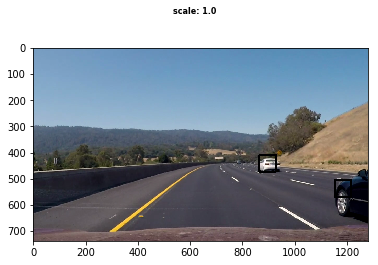

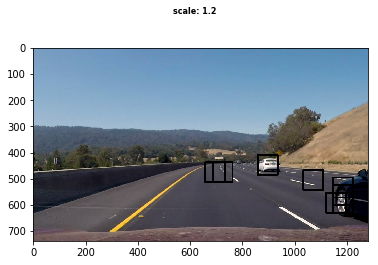

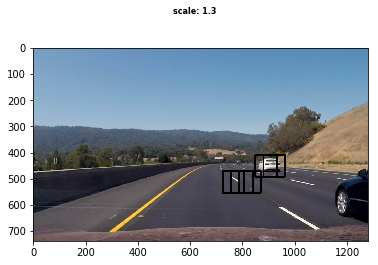

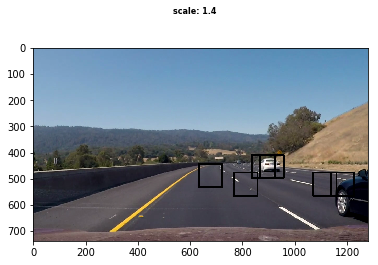

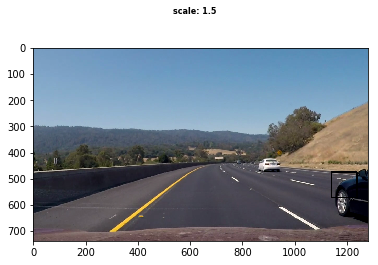

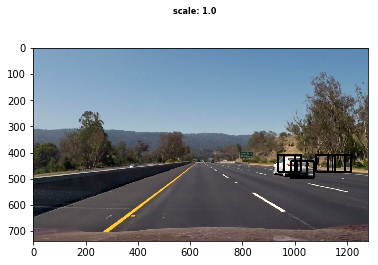

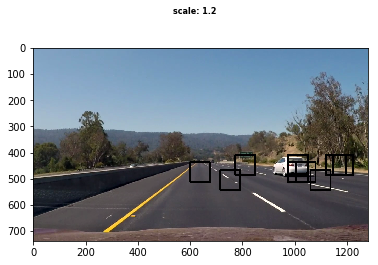

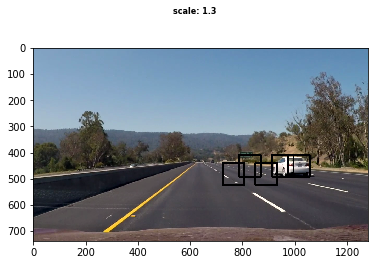

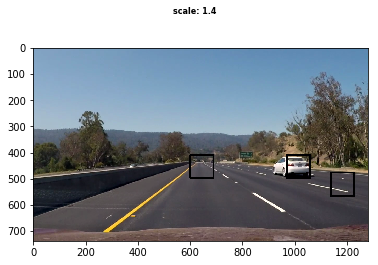

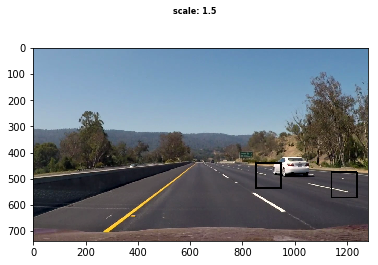

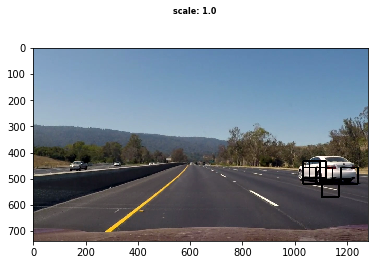

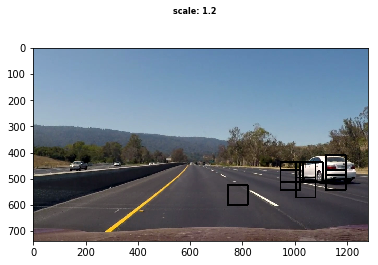

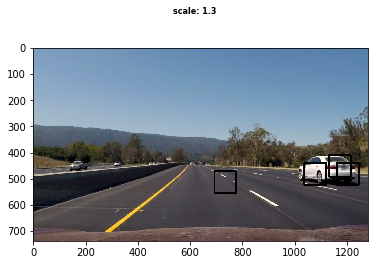

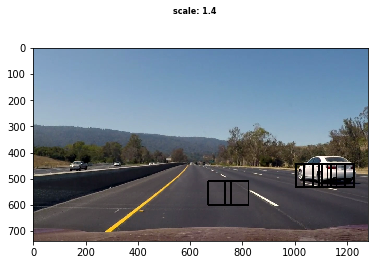

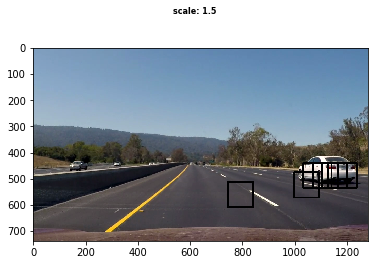

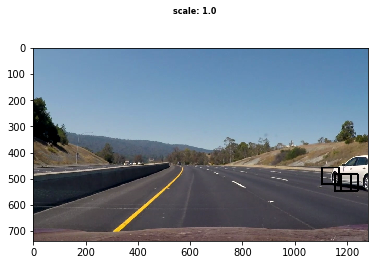

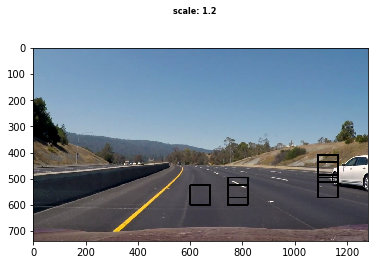

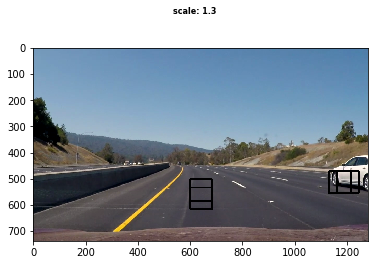

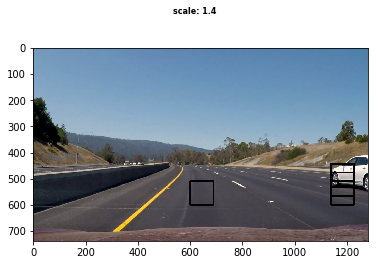

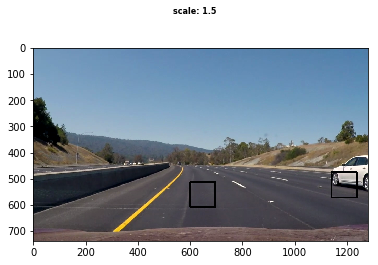

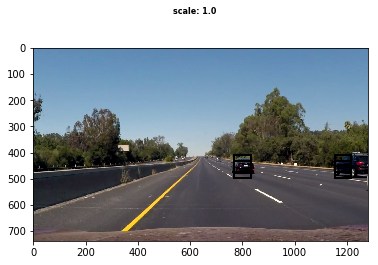

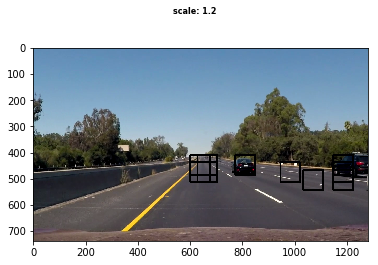

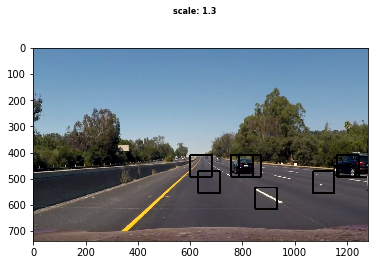

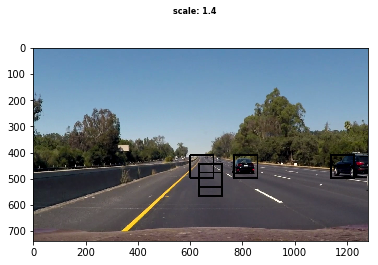

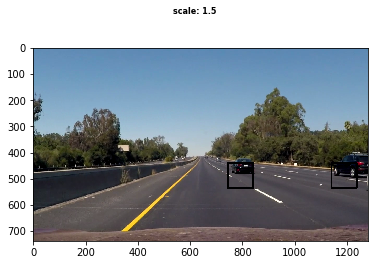

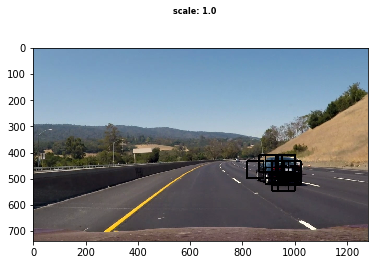

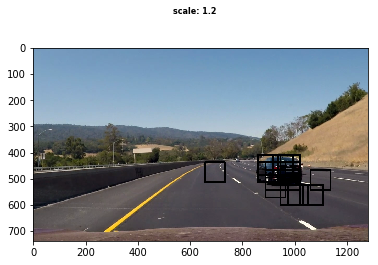

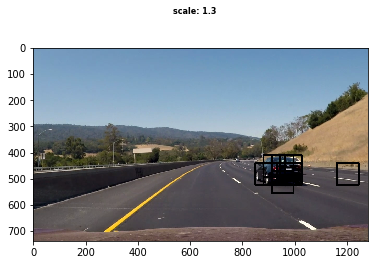

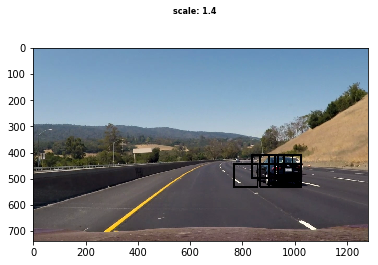

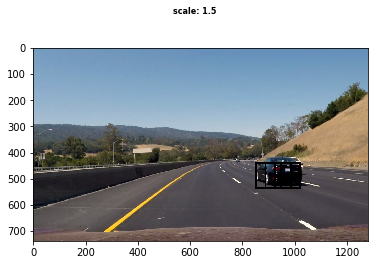

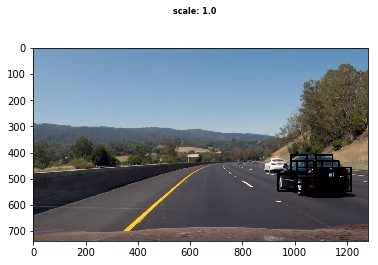

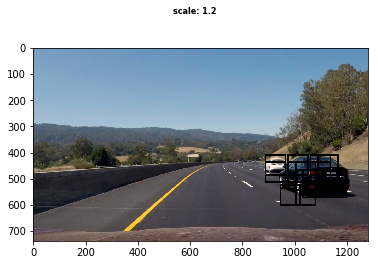

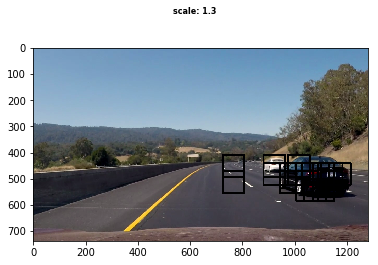

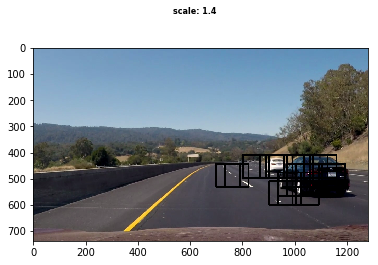

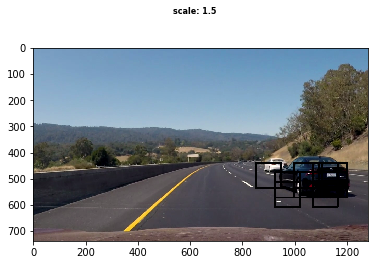

In [239]:
#define 3 ranges of search
#ystart, ystop, scale
ranges = [(410, 660, 1.0), (410, 660, 1.2), (410, 660, 1.3), (410, 660, 1.4), (440, 660, 1.5)]
#[
#    (380, 530, 1.0),
#    (400, 600, 1.9),
#    (500, 700, 2.3)
#]
xstart = 600
xstop = 1280

%matplotlib inline
for i in range(14, 7, -1):
    img = mpimg.imread('test_images/test'+ str(i) +'.png')
    for ystart, ystop, scale in ranges:
        fig = plt.figure()
        fig.suptitle('scale: '+ str(scale), fontsize=8, fontweight='bold')
        print (ystart, ystop, scale)
        out_img, bboxes = find_bboxes(img, xstart, xstop, ystart, ystop, scale, svc, X_scaler, orient, pix_per_cell, cell_per_block, spatial_size, hist_bins, color_space)
        plt.imshow(out_img)


In [240]:
import time
time_boxes = []

def pipeline(img):
    global time_boxes
    global xstart
    global xstop
    
    frames_lookback = 15
    heat_threshold = 50
    #ranges = [(360, 600, 1), (400, 600, 1.3), (440, 700, 1.5)]
    ranges = [(400, 560, 1.25), (410, 700, 1.9)]
    
    all_bboxes = []
    for ystart, ystop, scale in ranges:
        plt.figure()
        out_img, bboxes = find_bboxes(img, xstart, xstop, ystart, ystop, scale, svc, X_scaler, orient, pix_per_cell, cell_per_block, spatial_size, hist_bins)
        all_bboxes += bboxes
    
    time_boxes += all_bboxes
    
    time_boxes = [[a, b, c+1]  for [a, b, c] in time_boxes if c < frames_lookback]
    single_boxes = find_cars(img, time_boxes, heat_threshold)
    return single_boxes

In [241]:
from moviepy.editor import VideoFileClip
white_output = 'project_output.mp4'
clip1 = VideoFileClip("project_video.mp4")
white_clip = clip1.fl_image(pipeline) #NOTE: this function expects color images!!
%time white_clip.write_videofile(white_output, audio=False)

[MoviePy] >>>> Building video project_output.mp4
[MoviePy] Writing video project_output.mp4


100%|█████████▉| 1260/1261 [04:05<00:00,  5.55it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: project_output.mp4 

CPU times: user 3min 52s, sys: 11.6 s, total: 4min 4s
Wall time: 4min 6s
